## This notebook contains all the codes and the functions used in order to define the technical features of a football team and to compute the machine learning classifiers.

In [1]:
'''The data are stored in .json format; we use MongoDB and pymongo to read it'''
from pymongo import MongoClient

'''Basic functions'''
import pandas as pd
import numpy as np
import math as m
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

'''Statistical functions'''
from scipy import stats # Hypothesis tests functions
import statsmodels.api as sm
import statsmodels.stats.multicomp
from statsmodels.formula.api import ols # Linear model with ols parameter estimates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

'''Features Definition'''
from match_intensity import *
from H_indicator import * 
from flow_centrality import *

'''Machine learning Classifiers'''
from sklearn.linear_model import LogisticRegression # LOGISTIC REGRESSION
from sklearn.tree import (DecisionTreeClassifier, export_graphviz) # DECISION TREE
from sklearn.ensemble import RandomForestClassifier # RANDOM FOREST
from sklearn.ensemble import AdaBoostClassifier # ADABOOST 
from sklearn.dummy import DummyClassifier # BASELINE CLASSIFIERS

'''Choice of tuning parameters & Evaluation of predictive performance'''
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

'''Networks'''
import networkx as nx

import sys
import warnings 
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
'''
Connect to MongoDB, change the << MONGODB URL >> to reflect your own connection string

'''
client = MongoClient("mongodb://127.0.0.1:27017/?compressors=disabled&gssapiServiceName=mongodb") 

'''
NB the "dati" database it's been created by me and contains all the usefull collections 
(they were imported through the 'mongoimport' command in the mongo shell)

'''
db = client['dati']
#db.list_collection_names() ### uncomment to visualize the COLLECTIONS inside the database selected

In [3]:
'''
I extract and rename all the collections in the database

'''
teamsM = db.teams
teamsF = db.teamsW
playersM = db.players
playersF = db.playersW
eventsM = db.eventsWC
eventsF = db.eventsWCW
matchesM = db.matchesWC
matchesF = db.matchesWCW 

# <font color=orange>I</font>  Event-based Features Definition

---

# <font color=red>1.</font> Events count  

In [4]:
'''
Count, for every team in every match played, the number of each type of soccer events made.

Then, I filtered for the first and the second half, and  I delected the Interruption event in the female games, 
in order to avoid any distortion.

'''

eventM_period = list(eventsM.aggregate([{'$group': {'_id': {'match':'$matchId', 'team':'$teamId','eventName':'$eventName', 'period':'$matchPeriod'}, 'count':{'$sum':1}}},
                                      {'$project' : {'_id':1, 'count':1}}])) 
eventF_period = list(eventsF.aggregate([{'$group': {'_id': {'match':'$matchId', 'team':'$teamId','eventName':'$eventName', 'period':'$matchPeriod'}, 'count':{'$sum':1}}},
                                      {'$project' : {'_id':1, 'count':1}}]))

eventM_period = pd.DataFrame(eventM_period)
eventM_periods = pd.DataFrame([[x['match'],x['team'],x['eventName'],x['period'],y] for x,y in zip(eventM_period['_id'],eventM_period['count'])],columns=['match','team','event','period','count']).sort_values(by=['match','period'])

eventF_period = pd.DataFrame(eventF_period)
eventF_periods = pd.DataFrame([[x['match'],x['team'],x['eventName'],x['period'],y] for x,y in zip(eventF_period['_id'],eventF_period['count'])],columns=['match','team','event','period','count']).sort_values(by=['match','period'])

eventM_per = eventM_periods[(eventM_periods['period'] == '1H') | (eventM_periods['period'] == '2H')]
totEv_M = eventM_per.groupby(['match','team'], as_index=False)['count'].sum()
evM = pd.merge(totEv_M, eventM_per, on = ['match','team'])
evM = evM.rename({'count_x': 'TotCount', 'count_y': 'CountEv'}, axis='columns')
evM['Prop_Over_Total_Ev'] = evM['CountEv'] / evM['TotCount']
evM.insert(7, "gender", ['M']*len(evM), True) 

eventF_pers = eventF_periods[(eventF_periods['period'] == '1H') | (eventF_periods['period'] == '2H')]
eventF_per = eventF_pers[eventF_pers.event != 'Interruption']
totEv_F = eventF_per.groupby(['match','team'], as_index=False)['count'].sum()
evF = pd.merge(totEv_F, eventF_per, on = ['match','team'])
evF = evF.rename({'count_x': 'TotCount', 'count_y': 'CountEv'}, axis='columns')
evF['Prop_Over_Total_Ev'] = evF['CountEv'] / evF['TotCount']
evF.insert(7, "gender", ['F']*len(evF), True) 

frames = [evM, evF]
filterCount = pd.concat(frames)
filterCount.head(10)

,match,team,TotCount,event,period,CountEv,Prop_Over_Total_Ev,gender
0,2057954,14358,680,Duel,1H,111,0.163235,M
1,2057954,14358,680,Shot,1H,4,0.005882,M
2,2057954,14358,680,Pass,1H,145,0.213235,M
3,2057954,14358,680,Foul,1H,7,0.010294,M
4,2057954,14358,680,Offside,1H,3,0.004412,M
5,2057954,14358,680,Others on the ball,1H,32,0.047059,M
6,2057954,14358,680,Free Kick,1H,26,0.038235,M
7,2057954,14358,680,Foul,2H,15,0.022059,M
8,2057954,14358,680,Free Kick,2H,24,0.035294,M
9,2057954,14358,680,Duel,2H,110,0.161765,M


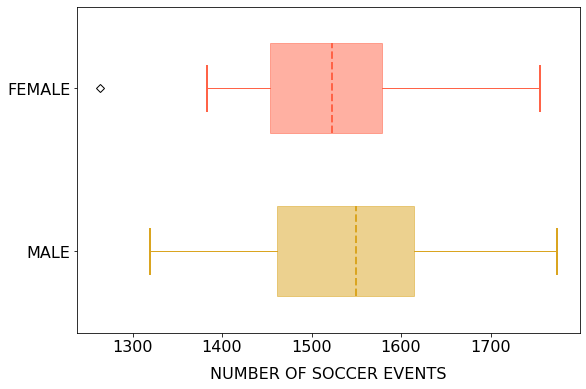

In [5]:
'''
Boxplots of the total number of events occurred during the Men World Cup 2018 matches and the Women World Cup 2019 matches.
The dashed line represents the averages. There are considered only the events occurred in the first and second half of a match.

'''
data_to_plot = [evM.groupby(by=['match'], as_index=False)['CountEv'].sum()['CountEv'], evF.groupby(by=['match'], as_index=False)['CountEv'].sum()['CountEv']]

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

bp = ax.boxplot(data_to_plot, vert=False, widths=0.55, patch_artist=True, showmeans=True, meanline=True)

box = bp['boxes']
median = bp['medians']
mean = bp['means']
whisker = bp['whiskers']
cap=bp['caps']

ax.set_yticklabels(['MALE', 'FEMALE'], fontsize=16,weight='book')
plt.xlabel('NUMBER OF SOCCER EVENTS', fontsize=16, labelpad=12)
plt.xticks(size=16)

box[0].set(color='goldenrod', alpha=0.5)
box[1].set(color='tomato',alpha=0.5)

median[0].set(linewidth=0)
median[1].set(linewidth=0)

mean[0].set(color='goldenrod', linewidth=2)
mean[1].set(color='tomato', linewidth=2)

whisker[0].set(color='goldenrod', linewidth=1,linestyle='-')
whisker[1].set(color='goldenrod', linewidth=1,linestyle='-')
whisker[2].set(color='tomato', linewidth=1,linestyle='-')
whisker[3].set(color='tomato', linewidth=1,linestyle='-')

cap[0].set(color='goldenrod', linewidth=2)
cap[1].set(color='goldenrod', linewidth=2)
cap[2].set(color='tomato', linewidth=2)
cap[3].set(color='tomato', linewidth=2)

for flier in bp['fliers']:
    flier.set(marker='D', color='blue')
plt.show()

# <font color=red>2.</font> Accurate passes

In [6]:
totPm_ = list(eventsM.aggregate([{'$match': {'eventName':'Pass'}},
    {'$group': {'_id': {'match':'$matchId','team':'$teamId'}, 'count':{'$sum':1}}}]))
totPf_ = list(eventsF.aggregate([{'$match': {'eventName':'Pass'}},
    {'$group': {'_id': {'match':'$matchId','team':'$teamId'}, 'count':{'$sum':1}}}])) 

accM_ = list(eventsM.aggregate([{'$match': {'eventName':'Pass', 'tags.id':1801}},
    {'$group': {'_id': {'match':'$matchId','team':'$teamId'}, 'count':{'$sum':1}}}]))
accF_ = list(eventsF.aggregate([{'$match': {'eventName':'Pass', 'tags.id':1801}},
    {'$group': {'_id': {'match':'$matchId','team':'$teamId'}, 'count':{'$sum':1}}}]))

totPass_M = pd.DataFrame(totPm_)
totPass_M  = pd.DataFrame([[x['match'],x['team'], y] for x,y in zip(totPass_M['_id'],totPass_M['count'])],columns=['match','team','count']).sort_values(by=['match'])
totPass_F = pd.DataFrame(totPf_)
totPass_F  = pd.DataFrame([[x['match'],x['team'], y] for x,y in zip(totPass_F['_id'],totPass_F['count'])],columns=['match','team','count']).sort_values(by=['match'])

accPass_M = pd.DataFrame(accM_)
accPass_M = pd.DataFrame([[x['match'],x['team'],y] for x,y in zip(accPass_M['_id'],accPass_M['count'])],columns=['match','team','count']).sort_values(by=['match'])
accPass_F = pd.DataFrame(accF_)
accPass_F = pd.DataFrame([[x['match'],x['team'],y] for x,y in zip(accPass_F['_id'],accPass_F['count'])],columns=['match','team','count']).sort_values(by=['match'])

accM = pd.merge(totPass_M, accPass_M, on = ['match','team'])
accM = accM.rename({'count_x': 'TotPass', 'count_y': 'AccurateP'}, axis='columns')
accM['RelAccP'] = accM['AccurateP'] / accM['TotPass']
accM.insert(5, "gender", ['M']*len(accM), True) 

accF = pd.merge(totPass_F, accPass_F, on = ['match','team'])
accF = accF.rename({'count_x': 'TotPass', 'count_y': 'AccurateP'}, axis='columns')
accF['RelAccP'] = accF['AccurateP'] / accF['TotPass']
accF.insert(5, "gender", ['F']*len(accF), True) 

frames = [accM, accF]
Accurate_Pass = pd.concat(frames)
Accurate_Pass.groupby(['gender'])['AccurateP'].mean(), Accurate_Pass.groupby(['gender'])['RelAccP'].mean()

(gender
 F    311.659091
 M    375.671875
 Name: AccurateP, dtype: float64, gender
 F    0.755873
 M    0.840585
 Name: RelAccP, dtype: float64)

Welch T-tests with independent samples.

Statistically verify if there is a difference in the number of accurate passes made by male and female national teams during the games.

$H_0 : \mu M - \mu F = 0$

$H_1 : \mu M - \mu F > 0$
  
- Normality and *different (real) sd* supposed ---> Welsh t-test with Satterthwait degrees of freedom is used;

- *Statistic unit* = a national soccer team in a match.

In [7]:
sm.stats.ttest_ind(Accurate_Pass['AccurateP'][Accurate_Pass.gender=='M'],Accurate_Pass['AccurateP'][Accurate_Pass.gender=='F'], usevar = 'unequal', value=0, alternative='larger')

(3.4896469807046158, 0.00029845035204033494, 196.65557026481966)

In [8]:
'''Merge the two dataframes (filterCount & Accurate_Pass) and slightly change their layout'''

mod = filterCount.groupby(by=['team', 'match','gender','event'], as_index=False)['CountEv'].sum()
mod = mod.reset_index().groupby(['match', 'team','event'])['CountEv'].aggregate('first').unstack().fillna(0)
mod.reset_index(level=[0,1], inplace=True)

count_df = pd.merge(mod, Accurate_Pass, on =['match', 'team'])
count_df.head(10)

,match,team,Duel,Foul,Free Kick,Goalkeeper leaving line,Offside,Others on the ball,Pass,Save attempt,Shot,TotPass,AccurateP,RelAccP,gender
0,2057954,14358,221.0,22.0,50.0,0.0,3.0,62.0,311.0,0.0,11.0,311,243,0.781350,M
1,2057954,16521,247.0,10.0,55.0,0.0,1.0,66.0,516.0,7.0,7.0,516,455,0.881783,M
2,2057955,15670,219.0,6.0,38.0,1.0,1.0,95.0,579.0,3.0,11.0,579,499,0.861831,M
3,2057955,16129,227.0,12.0,42.0,4.0,1.0,68.0,421.0,4.0,7.0,421,345,0.819477,M
4,2057956,14358,259.0,10.0,57.0,1.0,0.0,87.0,385.0,1.0,12.0,385,311,0.807792,M
5,2057956,16129,231.0,10.0,51.0,5.0,0.0,73.0,420.0,5.0,12.0,420,348,0.828571,M
6,2057957,15670,164.0,10.0,40.0,4.0,1.0,68.0,473.0,3.0,13.0,473,410,0.866808,M
7,2057957,16521,163.0,13.0,45.0,3.0,2.0,76.0,553.0,4.0,7.0,553,482,0.871609,M
8,2057958,14358,183.0,19.0,38.0,0.0,2.0,75.0,327.0,8.0,3.0,327,271,0.828746,M
9,2057958,15670,173.0,17.0,54.0,2.0,0.0,37.0,466.0,1.0,12.0,466,405,0.869099,M


# <font color=red>3.</font> Pass length 

The *pass length* feature is defined based on the **actions split** algorithm taken from:

- Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. Sci Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

- Pappalardo, L., Cintia, P., Ferragina, P., Massucco, E., Pedreschi, D., Giannotti, F. (2019) PlayeRank: Data-driven Performance Evaluation and Player Ranking in Soccer via a Machine Learning Approach. ACM Transactions on Intellingent Systems and Technologies 10(5) Article 59, DOI: https://doi.org/10.1145/3343172, https://dl.acm.org/citation.cfm?id=3343172

In [9]:
avg_LenPass(match_id = 2058017) # Russia male World Cup final, France vs Croatia

,team,match,avgLenPass(mt)
0,4418.0,2058017.0,19.643792
1,9598.0,2058017.0,19.736393


In [10]:
'''
Now you can use the 'avg_LenPass' function for every match you have (about 3 minutes to run)

'''
matches = []
for m in matchesM.find(): 
    matches.append(m['wyId'])

len_p = {}
for match in matches:
    len_p[match] = avg_LenPass(match_id=match)   

len_pass_M = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in len_p.items()))
len_pass_M.head(10)

,team,match,avgLenPass(mt)
0,4418.0,2058014,20.880823
1,5629.0,2058014,19.756105
0,4418.0,2058017,19.643792
1,9598.0,2058017,19.736393
0,4418.0,2058010,21.749894
1,15670.0,2058010,17.911291
0,2413.0,2058013,22.774304
1,7047.0,2058013,22.051515
0,9598.0,2058012,21.087994
1,14358.0,2058012,23.209569


In [11]:
matchesf = []
for t in matchesF.find():
    matchesf.append(t['wyId'])

len_pf = {}
for match in matchesf:
    len_pf[match] = avg_LenPass_F(match_id=match)  
    
len_pass_F = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in len_pf.items()))
len_pass_F.head(10)

,team,match,avgLenPass(mt)
0,12914,2829616,20.289430
1,665,2829616,18.362192
0,1599,2829613,20.108402
1,8133,2829613,20.608875
0,16777,2829611,18.613268
1,2414,2829611,19.365377
0,3758,2829615,18.585157
1,9210,2829615,19.466226
0,16824,2829609,20.651473
1,3149,2829609,21.545445


Welch T-test on the *avgLenPass* feature:

$H_0 : \mu M - \mu F = 0$

$H_1 : \mu M - \mu F > 0$

In [12]:
sm.stats.ttest_ind(len_pass_M['avgLenPass(mt)'],len_pass_F['avgLenPass(mt)'], usevar = 'unequal', value=0, alternative='larger')

(3.539506248162679, 0.0002494680523350327, 199.2098464552466)

# <font color=red>4.</font> Shots distance

In [13]:
'''
In the shots distance measure I consider: (I) the shots in motion, (II) the free-kick shots.
 
Every shot distances is measured from the real "from" position to the goal center, i.e. the [100, 50] field position; this is 
because the Euclidean distance from the starting point of the shot to the goal center is the same regardless of where a team is attacking to.

Finally it was defined the average shots' Euclidean distance made by a national team in a match.

'''
targM = list(eventsM.aggregate([{'$match': {'$or':[{'eventName':'Shot'}, {'subEventId':33}]}},
    {'$group': {'_id':{'match':'$matchId','team':'$teamId','pos':'$positions','event':'$subEventName'}, 'count':{'$sum':1}}}]))
targF = list(eventsF.aggregate([{'$match': {'$or':[{'eventName':'Shot'}, {'subEventId':33}]}},
    {'$group': {'_id':{'match':'$matchId','team':'$teamId','pos':'$positions','event':'$subEventName'}, 'count':{'$sum':1}}}]))

targM = pd.DataFrame(targM)
targetM = pd.DataFrame([[x['match'],x['team'],x['pos'],x['event'],y] for x,y in zip(targM['_id'], targM['count'])], columns = ['match','team','pos','event','count'])
targF = pd.DataFrame(targF)
targetF = pd.DataFrame([[x['match'],x['team'],x['pos'],x['event'],y] for x,y in zip(targF['_id'], targF['count'])], columns = ['match','team','pos','event','count'])

'''Extract the 'from' positions vectors and convert them to meters (considering the pitch length and width 110 x 65)'''

posM = list(targetM['pos'])
posF = list(targetF['pos'])

from_y = []
from_x = []

for i in range(len(posM)):
    from_y.append(posM[i][0]['y'])
for i in range(len(posM)):
    from_x.append(posM[i][0]['x'])
    
from_yf = []
from_xf = []

for i in range(len(posF)):
    from_yf.append(posF[i][0]['y'])
for i in range(len(posF)):
    from_xf.append(posF[i][0]['x'])

fr_y = [i * 65 for i in from_y]
fro_y = [i /100 for i in fr_y]
fr_x = [i * 110 for i in from_x]
fro_x = [i /100 for i in fr_x]

fr_yf = [i * 65 for i in from_yf]
fro_yf = [i /100 for i in fr_yf]
fr_xf = [i * 110 for i in from_xf]
fro_xf = [i /100 for i in fr_xf]

targetM['from_y'] = fro_y
targetM['from_x'] = fro_x
targetM['to_y'] = [32.5] * len(targetM)
targetM['to_x'] = [110] * len(targetM)
targetM.insert(9, "gender", ['M']*len(targetM), True) 

targetF['from_y'] = fro_yf
targetF['from_x'] = fro_xf
targetF['to_y'] = [32.5] * len(targetF)
targetF['to_x'] = [110] * len(targetF)
targetF.insert(9, "gender", ['F']*len(targetF), True) 

'''Duplicate the shots 'count' times...'''
targetM = targetM.loc[targetM.index.repeat(targetM['count'])]
targetF = targetF.loc[targetF.index.repeat(targetF['count'])]

targetM['EucDist'] = (((targetM['to_x'] - targetM['from_x'])**2) + ((targetM['to_y'] - targetM['from_y'])**2))**0.5
targetF['EucDist'] = (((targetF['to_x'] - targetF['from_x'])**2) + ((targetF['to_y'] - targetF['from_y'])**2))**0.5
targetM = targetM.drop(targetM[targetM['EucDist']>=58].index) # DELETE THESE 6 ROWS WITH STRANGE POSITIONS!

targetM = targetM.groupby(by=['match', 'team', 'gender'], as_index=False)['EucDist'].mean()
targetF = targetF.groupby(by=['match', 'team','gender'], as_index=False)['EucDist'].mean()

target = pd.concat([targetM, targetF])
target.head(10)

,match,team,gender,EucDist
0,2057954,14358,M,17.685036
1,2057954,16521,M,21.391255
2,2057955,15670,M,21.038238
3,2057955,16129,M,23.027910
4,2057956,14358,M,21.903540
5,2057956,16129,M,17.847202
6,2057957,15670,M,16.851638
7,2057957,16521,M,23.821995
8,2057958,14358,M,22.202500
9,2057958,15670,M,19.797312


In [14]:
def pitch():
    """
    Code to plot a soccer pitch.
    
    It is taken from:
    - Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. 
    Sci Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

    - Pappalardo, L., Cintia, P., Ferragina, P., Massucco, E., Pedreschi, D., Giannotti, F. (2019) 
    PlayeRank: Data-driven Performance Evaluation and Player Ranking in Soccer via a Machine Learning Approach. 
    ACM Transactions on Intellingent Systems and Technologies 10(5) Article 59, 
    DOI: https://doi.org/10.1145/3343172, https://dl.acm.org/citation.cfm?id=3343172
    
    """
    #create figure
    fig,ax=plt.subplots(figsize=(4.5,3.2))
    
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,100], color="black")
    plt.plot([0,100],[100,100], color="black")
    plt.plot([100,100],[100,0], color="black")
    plt.plot([100,0],[0,0], color="black")
    plt.plot([50,50],[0,100], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[80,20],color="black")
    plt.plot([0,16.5],[80,80],color="black")
    plt.plot([16.5,0],[20,20],color="black")

    #Right Penalty Area
    plt.plot([83.5,100],[80,80],color="black")
    plt.plot([83.5,83.5],[80,20],color="black")
    plt.plot([83.5,100],[20,20],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[65,65],color="black")
    plt.plot([5.5,5.5],[65,35],color="black")
    plt.plot([5.5,0.5],[35,35],color="black")

    #Right 6-yard Box
    plt.plot([100,94.5],[65,65],color="black")
    plt.plot([94.5,94.5],[65,35],color="black")
    plt.plot([94.5,100],[35,35],color="black")

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor="black", facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    plt.xlim(0,100)
    plt.ylim(0,100)
    
    ax.annotate("", xy=(25, 5), xytext=(5, 5),
                arrowprops=dict(arrowstyle="->", linewidth=1))
    ax.text(7,9,'Attack',fontsize=12)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    return fig,ax

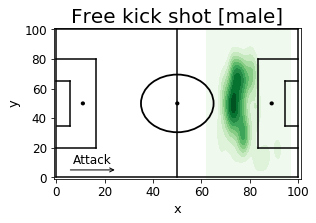

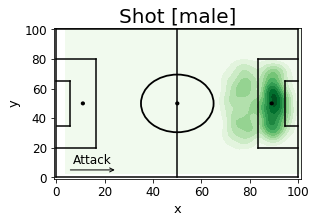

In [15]:
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse

def plot_kde_events_on_field(sample_size=10000):
    """
    Generate density plots on the field for each event type you want. Here we consider from where male football players made 
    'Shots' and 'Free Kick shots', during the Russia 2018 World Cup.
    
    Parameters
    ----------
    sample_size: int
        random sample of values to use (default: 10000). The code becomes slow is you increase this value
        significantly.
    """
    position_ev = []
    for ev in eventsM.find({'$or':[{'eventName':'Shot'}, {'subEventId':33}]}): # changed into 'eventsF.find()' when using female dataset 
            position_ev.append([ev['subEventName'],ev['positions'][0]['x'],ev['positions'][0]['y']])

    df_pos_ev = pd.DataFrame(position_ev, columns=['eventName','x','y'])

    for event in np.unique(df_pos_ev['eventName']):
#         print(event)
        df_pos_event = df_pos_ev[df_pos_ev['eventName'] == event]
        fig,ax = pitch()
        if len(df_pos_event) >= 10000:
            x_y = df_pos_event[['x','y']].sample(sample_size).astype(float)
        else:
            x_y = df_pos_event[['x','y']].astype(float)
        sns.kdeplot(x_y['x'],x_y['y'], cmap = 'Greens', shade = True)
        plt.title(event + ' [male]', fontsize = 20) # write ['female'] instead of ['male'] when using the female dataset
        plt.xlabel('x', fontsize = 13)
        plt.ylabel('y',fontsize = 13)
        plt.xlim(-1,101)
        plt.ylim(-1,101)
        plt.axis('on')
        fig.tight_layout()
        plt.show() 
        
plot_kde_events_on_field()

# <font color=red>5.</font> Match Intensity

All the match intensity features are defined based again on the **actions split** algorithm taken from:

- Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. Sci Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

- Pappalardo, L., Cintia, P., Ferragina, P., Massucco, E., Pedreschi, D., Giannotti, F. (2019) PlayeRank: Data-driven Performance Evaluation and Player Ranking in Soccer via a Machine Learning Approach. ACM Transactions on Intellingent Systems and Technologies 10(5) Article 59, DOI: https://doi.org/10.1145/3343172, https://dl.acm.org/citation.cfm?id=3343172

## <font color=red>5.1</font> Pass velocity & Ball possession recovery time

In [16]:
avg_pass_rec_time(match_id = 2058017) # Russia World Cup final, France vs Croatia

,team,passTime,recoveryTime
0,4418,2.675076,38.239973
1,9598,3.257374,27.141081


In [17]:
'''
Now you can use the 'avg_pass_rec_time' function for every match you have (about 4 minutes to run)

'''
matches = []
for m in matchesM.find(): 
    matches.append(m['wyId'])

time_p = {}
for match in matches:
    time_p[match] = avg_pass_rec_time(match_id=match)

time_pass_M = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in time_p.items()))
time_pass_M.head(10)

,team,passTime,recoveryTime,match
0,4418,3.006803,41.606224,2058014
1,5629,2.682103,38.981271,2058014
0,4418,2.675076,38.239973,2058017
1,9598,3.257374,27.141081,2058017
0,4418,2.842901,23.227782,2058010
1,15670,2.692908,34.296487,2058010
0,2413,3.032850,30.152461,2058013
1,7047,3.110795,36.564346,2058013
0,9598,3.158215,21.818144,2058012
1,14358,2.756899,35.976222,2058012


In [18]:
matchesf = []
for t in matchesF.find():
    matchesf.append(t['wyId'])

time_pf = {}
for match in matchesf:
    time_pf[match] = avg_pass_rec_time_F(match_id=match)

time_pass_F = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in time_pf.items()))
time_pass_F.head(10)

,team,passTime,recoveryTime,match
0,12914,2.655643,26.920572,2829616
1,665,2.899076,23.935010,2829616
0,1599,2.630608,44.218410,2829613
1,8133,2.829375,28.944802,2829613
0,16777,2.650843,33.827691,2829611
1,2414,2.491226,19.660525,2829611
0,3758,2.553484,29.698985,2829615
1,9210,2.233619,18.620690,2829615
0,16824,2.561349,50.296310,2829609
1,3149,2.773218,23.123791,2829609


Example of Mann-Whitney U-test on the **recoveryTime** feature. Similar ro the Welch t-test, it compares 2 independent samples obtained from two continuous random variables X and Y, with distribution functions Fx(u) and Fy(u).

$H_0 : F_{male}(u) = F_{female}(u)$

$H_1 : F_{male}(u) > F_{female}(u)$

In [19]:
stats.mannwhitneyu(time_pass_M['recoveryTime'], time_pass_F['recoveryTime'], alternative = 'greater') 

MannwhitneyuResult(statistic=8048.0, pvalue=4.347778541544073e-08)

## <font color=red>5.2</font> Duel & Shooting time

In [20]:
avg_duel_shot_time(match_id = 2058017) # Russia World Cup final, France vs Croatia

,ContrastTeam,match,difDuel,difShot
0,4418,2058017,147.004405,345.300304
1,9598,2058017,45.739618,280.808808


In [21]:
'''
Now you can use the 'avg_duel_shot_time' function for every match you have (about 4 minutes to run)

'''
matches = []
for m in matchesM.find():  
    matches.append(m['wyId'])

duel_shot = {}
for match in matches:
    duel_shot[match] = avg_duel_shot_time(match_id=match)

duel_shot_M = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in duel_shot.items()))
duel_shot_M.head(10)

,ContrastTeam,match,difDuel,difShot
0,4418,2058014,68.712376,242.330121
1,5629,2058014,65.025419,264.459570
0,4418,2058017,147.004405,345.300304
1,9598,2058017,45.739618,280.808808
0,4418,2058010,34.609958,381.341936
1,15670,2058010,85.552146,157.329415
0,2413,2058013,66.322541,295.450780
1,7047,2058013,55.711405,292.645276
0,9598,2058012,55.381173,257.787830
1,14358,2058012,65.980020,580.127785


In [22]:
matchesf = []
for t in matchesF.find():
    matchesf.append(t['wyId'])

duel_shotf = {}
for match in matchesf:
    duel_shotf[match] = avg_duel_shot_time_F(match_id=match)

duel_shot_F = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in duel_shotf.items()))
duel_shot_F.head(10)

,ContrastTeam,match,difDuel,difShot
0,12914,2829616,62.797411,292.343787
1,665,2829616,175.114676,391.500525
0,1599,2829613,153.859526,300.870059
1,8133,2829613,40.332418,309.255292
0,16777,2829611,77.722917,469.555280
1,2414,2829611,58.479368,519.686156
0,3758,2829615,60.870161,315.633200
1,9210,2829615,54.787920,186.588486
0,16824,2829609,52.949297,1073.444734
1,3149,2829609,129.388819,375.922305


## <font color=red>5.3</font> Stop Game Duration

In [23]:
stop_time(match_id = 2058017) 

,beneficiaryTeam,avg_stopTime,match
0,4418,23.037118,2058017
1,9598,15.368876,2058017


In [24]:
'''
Now you can use the 'stop_time' function for every Russia 2018 World Cup match you have (about 4 minutes to run)

'''
matches = []
for m in matchesM.find():
    matches.append(m['wyId'])
    
stop_t = {}
for match in matches:
    stop_t[match] = stop_time(match_id=match)    

stop_time_M = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in stop_t.items()))
stop_time_M.head(10)

,beneficiaryTeam,avg_stopTime,match
0,4418,26.661540,2058014
1,5629,21.269000,2058014
0,4418,23.037118,2058017
1,9598,15.368876,2058017
0,4418,25.108951,2058010
1,15670,17.823747,2058010
0,2413,25.547211,2058013
1,7047,21.850525,2058013
0,9598,20.055236,2058012
1,14358,27.075215,2058012


In [25]:
stop_timef(match_id = 2826535) # France 2019 World Cup game, Netherlands - Cameroon

,beneficiaryTeam,avg_stopTime,match
0,16777,17.964782,2826535
1,665,23.190901,2826535


In [26]:
'''
Now you can use the 'stop_timef' function for every France 2019 World Cup match you have (about 4 minutes to run)

'''
matchesf = []
for t in matchesF.find():
    matchesf.append(t['wyId'])

stop_tf = {}
for match in matchesf:
    stop_tf[match] = stop_timef(match_id=match)  
    
stop_time_F = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in stop_tf.items()))
stop_time_F.head(10)

,beneficiaryTeam,avg_stopTime,match
0,12914,16.395330,2829616
1,665,18.125925,2829616
0,1599,19.420394,2829613
1,8133,30.342339,2829613
0,16777,22.979212,2829611
1,2414,18.266008,2829611
0,3758,18.111005,2829615
1,9210,13.719725,2829615
0,16824,23.518021,2829609
1,3149,24.741835,2829609


# <font color=red>6.</font> Performance Synthetic Indicators
## <font color=red>6.1</font> H Indicator

The H Indicator is defined by the harmonic mean of these five passing performance indicators of a team in certain match of interest:

(I) $w$: the number of passes managed by the team in the game;
(II) $\mu_p$: average amount of passes managed by players in a team during a game;
(III) $\sigma_p$: the variance of the amount of passes managed by players in a team during a game;
(IV) $\mu_z$: average amount of passes managed by zones of the pitch during the game;
(V) $\sigma_z$: the variance of the amount of passes managed by zones of the pitch during the game.

In [27]:
passing_network(match_Id = 2058017) 

,meanp,stdp,w
France,4.884211,4.036702,464
Croatia,2.150538,1.102825,200


In [28]:
zone_network(match_Id = 2058017)

,meanz,stdz
France,1.165899,0.450956
Croatia,1.073892,0.280484


In [29]:
pass_Net = passing_network(match_Id = 2058017)
zone_Net = zone_network(match_Id = 2058017)

pass_Net.reset_index(inplace=True)
pass_Net.rename({'index':'team'}, inplace = True, axis=1)
zone_Net.reset_index(inplace=True)
zone_Net.rename({'index':'team'}, inplace = True, axis=1)

final = pd.merge(pass_Net, zone_Net, on=['team'], how='outer')
final['H_ind'] = 5/((1/final['w']) + (1/final['meanp']) + (1/final['stdp']) + (1/final['meanz']) + (1/final['stdz']))

final

,team,meanp,stdp,w,meanz,stdz,H_ind
0,France,4.884211,4.036702,464,1.165899,0.450956,1.416493
1,Croatia,2.150538,1.102825,200,1.073892,0.280484,0.851322


In [30]:
'''
I measured the H Indicator for every (male) national team in every match (about 10 minutes to run).

'''
matches = []
for t in matchesM.find():
    matches.append(t['wyId'])

passM = {} 
for match in matches:
    passM[match] = passing_network(match_Id = match)

zoneM = {}
for match in matches:
    zoneM[match] = zone_network(match_Id = match)
    
Hind_M = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in passM.items()))
zonesM = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in zoneM.items()))

Hind_M['meanz'] = zonesM['meanz']
Hind_M['stdz'] = zonesM['stdz']
Hind_M.reset_index(inplace=True)
Hind_M.rename({'index':'team'}, inplace = True, axis=1)

Hind_M['H_ind'] = 5/((1/Hind_M['w']) + (1/Hind_M['meanp']) + (1/Hind_M['stdp']) + (1/Hind_M['meanz']) + (1/Hind_M['stdz']))
Hind_M.replace({'team' : {'Korea': 'Korea Republic', 'Saudi': 'Saudi Arabia', 'Costa':'Costa Rica'}}, inplace = True)

Hind_M.head(10)

,team,meanp,stdp,w,match,meanz,stdz,H_ind
0,France,3.152174,2.085717,290,2058014,1.118280,0.384487,1.164079
1,Belgium,5.474227,5.699219,531,2058014,1.266667,0.647077,1.855353
2,France,4.884211,4.036702,464,2058017,1.165899,0.450956,1.416493
3,Croatia,2.150538,1.102825,200,2058017,1.073892,0.280484,0.851322
4,Uruguay,2.833333,1.891732,255,2058010,1.100806,0.351284,1.077445
5,France,4.659794,3.526349,452,2058010,1.239295,0.632190,1.730638
6,Sweden,3.445783,2.369795,286,2058013,1.093750,0.356467,1.127325
7,England,4.420000,3.146844,442,2058013,1.125592,0.372268,1.213314
8,Russia,5.524752,4.367136,558,2058012,1.189349,0.494680,1.527145
9,Croatia,3.382716,2.255925,274,2058012,1.086643,0.340080,1.086177


In [31]:
matchesf = []
for t in matchesF.find():
    matchesf.append(t['wyId'])
    
passF = {} 
for match in matchesf:
    passF[match] = passing_network_F(match_Id = match)

zoneF = {}
for match in matchesf:
    zoneF[match] = zone_network_F(match_Id = match)
    
Hind_F = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in passF.items()))
zonesF = pd.concat((i_value_df.assign(match=i_key) for i_key, i_value_df in zoneF.items()))

Hind_F['meanz'] = zonesF['meanz']
Hind_F['stdz'] = zonesF['stdz']
Hind_F.reset_index(inplace=True)
Hind_F.rename({'index':'team'}, inplace = True, axis=1)

Hind_F['H_ind'] = 5/((1/Hind_F['w']) + (1/Hind_F['meanp']) + (1/Hind_F['stdp']) + (1/Hind_F['meanz']) + (1/Hind_F['stdz']))
Hind_F.replace({'team' : {'China': 'China PR', 'South': 'South Africa', 'New':'New Zealand', 'United': 'United States','Korea': 'Korea Republic'}}, inplace = True)
Hind_F.head(10)

,team,meanp,stdp,w,match,meanz,stdz,H_ind
0,Netherlands,4.574257,3.308615,462,2829616,1.169856,0.445979,1.381183
1,Japan,5.000000,3.914127,520,2829616,1.200000,0.542186,1.594832
2,Spain,2.957447,1.933935,278,2829613,1.057348,0.247886,0.856358
3,United States,3.817204,2.824375,355,2829613,1.103152,0.348587,1.137898
4,England,5.214286,3.437963,511,2829611,1.188312,0.457800,1.424300
5,Cameroon,2.717949,1.857924,212,2829611,1.064220,0.263798,0.886319
6,Italy,5.103896,3.291074,393,2829615,1.088889,0.293494,1.035643
7,China PR,2.772152,2.062792,219,2829615,1.057269,0.232869,0.820995
8,Germany,2.333333,1.503963,133,2829609,1.057971,0.263832,0.856679
9,Nigeria,4.056338,2.506491,288,2829609,1.100334,0.322480,1.073250


In [32]:
'''
Having the H Indicator for every team in every match, I take the average over the matches 
just to look at the first 5 male and female national teams.

'''
Hind_m = Hind_M.groupby(by=['team'])['H_ind'].mean().sort_values(ascending=False)
Hind_f = Hind_F.groupby(by=['team'])['H_ind'].mean().sort_values(ascending=False)

In [33]:
Hind_m.head(), Hind_f.head()

(team
 Spain        1.670242
 Egypt        1.604047
 Denmark      1.591553
 Australia    1.537647
 Iran         1.469587
 Name: H_ind, dtype: float64, team
 Japan           1.564578
 England         1.529879
 Chile           1.517678
 Scotland        1.404612
 South Africa    1.343809
 Name: H_ind, dtype: float64)

## <font color=red>6.2</font> Team Flow Centrality

In [34]:
var_team_flow(team_id = 12274) # ARGENTINA Male National Team

,match,var_team_flow
0,2057972,0.000465
1,2057974,0.000266
2,2057976,0.000527
3,2058003,0.000307


In [8]:
'''
Here I measure the average and the variance flow centrality for all the national teams in the Russia 2018 World Cup. 

NB It takes around 70 minutes to run!

''' 
teams = []
for t in eventsM.find():
    teams.append(t['teamId'])
    teams = list(set(teams)) # Select just the unique values

team_avg_flow = {} 
for team in teams:
    team_avg_flow[team] = avg_team_flow(team_id=team)

df_list_avg = [ v for k,v in team_avg_flow.items()] 
team_AVG_flow = pd.concat(df_list_avg, keys=team_avg_flow.keys(), axis=0)
team_AVG_flow = team_AVG_flow.reset_index()
team_AVG_flow.drop('level_1', axis=1, inplace=True)
team_AVG_flow.rename({'level_0':'team'}, axis=1, inplace=True)

team_AVG_flow.head(10)

match  avg_team_flow
16129 0  2057955       0.055406
      1  2057956       0.057339
      2  2057959       0.055189
14855 0  2057985       0.065214
      1  2057987       0.058325
      2  2057988       0.059948
7047  0  2057985       0.056808
      1  2057986       0.055858
      2  2057989       0.050433
      3  2058008       0.060904

In [25]:
team_var_flow = {}
for team in teams:
    team_var_flow[team] = var_team_flow(team_id=team)
    
df_list_var = [ v for k,v in team_var_flow.items()] 
team_VAR_flow = pd.concat(df_list_var, keys=team_var_flow.keys(), axis=0)
team_VAR_flow = team_VAR_flow.reset_index()
team_VAR_flow.drop('level_1', axis=1, inplace=True)
team_VAR_flow.rename({'level_0':'team'}, axis=1, inplace=True)

team_VAR_flow.head(10)

,team,match,var_team_flow
0,16129,2057955,0.000284
1,16129,2057956,0.000864
2,16129,2057959,0.000344
3,14855,2057985,0.000458
4,14855,2057987,0.000322
5,14855,2057988,0.000433
6,7047,2057985,0.000951
7,7047,2057986,0.000388
8,7047,2057989,0.000301
9,7047,2058008,0.000837


In [ ]:
# team_VAR_flow.replace({'var_team_flow' : {'9,16E+10':  0.0001}}, inplace = True) # sometimes happens this error

In [36]:
'''
Here I measure the average and the variance flow centrality for all the national teams in the France 2019 World Cup. 

NB It takes around 70 minutes to run!

'''
teamsf = []
for t in eventsF.find():
    teamsf.append(t['teamId'])
    teamsf = list(set(teamsf))
teamsf = [ int(x) for x in teamsf ]

teamF_avg_flow = {} 
for teamf in teamsf:
    teamF_avg_flow[teamf] = avg_team_flow_F(team_id=teamf)

teamF_var_flow = {}
for teamf in teamsf:
    teamF_var_flow[teamf] = var_team_flow_F(team_id=teamf) 
    
df_list_avg = [ v for k,v in teamF_avg_flow.items()] 
team_F_AVG_flow = pd.concat(df_list_avg, keys=teamF_avg_flow.keys(), axis=0)
team_F_AVG_flow = team_F_AVG_flow.reset_index()
team_F_AVG_flow.drop('level_1', axis=1, inplace=True)
team_F_AVG_flow.rename({'level_0':'team'}, axis=1, inplace=True)

    
df_list_var = [ v for k,v in teamF_var_flow.items()] 
team_F_VAR_flow = pd.concat(df_list_var, keys=teamF_var_flow.keys(), axis=0)
team_F_VAR_flow = team_F_VAR_flow.reset_index()
team_F_VAR_flow.drop('level_1', axis=1, inplace=True)
team_F_VAR_flow.rename({'level_0':'team'}, axis=1, inplace=True)

team_F_VAR_flow.head(10)

,team,match,var_team_flow
0,665,2826534,0.000204
1,665,2826535,0.000416
2,665,2826537,0.000633
3,665,2829616,0.000395
4,12914,2826528,0.000603
5,12914,2826529,0.000276
6,12914,2826531,0.000598
7,12914,2829616,0.000322
8,16425,2826515,0.000188
9,16425,2826517,0.000404


In [ ]:
# team_F_VAR_flow.replace({'var_team_flow' : {'6,99E+08':  0.0001}}, inplace = True) # sometimes happens this error

## <font color=red>6.3</font> PlayeRank

**References**:

Playerank -- Pappalardo, L., Cintia, P., Ferragina, P., Massucco, E., Pedreschi, D., & Giannotti, F. (2019). PlayeRank: data-driven performance evaluation and player ranking in soccer via a machine learning approach. ACM Transactions on Intelligent Systems and Technology (TIST), 10(5), 59.

Public dataset -- Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi & Fosca Giannotti (2019). Nature Scientic Data

In [6]:
from playerank.features import relativeAggregation,centerOfPerformanceFeature,qualityFeatures,playerankFeatures, plainAggregation, matchPlayedFeatures,roleFeatures,goalScoredFeatures
from playerank.models import Rater, Weighter, Clusterer
import sys,json
import pandas as pd

In [5]:
qualityFeat = qualityFeatures.qualityFeatures()
quality= qualityFeat.createFeature(events_path = 'data/events',
                        players_file='data/players.json' ,entity = 'team') # the entity for quality features is the TEAM
gs=goalScoredFeatures.goalScoredFeatures()
goals=gs.createFeature('data/matches')

#merging of quality features and goals scored
aggregation = relativeAggregation.relativeAggregation()
aggregation.set_features([quality,goals])
df = aggregation.aggregate(to_dataframe = True)

weighter = Weighter.Weighter(label_type='w-dl') # SVC (linear boundary and the beta_j estimated will be the weights); RESPONSE VAR. => 1 if win, 0 if draw or lose
output_path = "feature_weights.json"
weighter.fit(df, target = 'Shot-Shot-accurate',  var_threshold = 0.02,filename=output_path)
print ("features weights stored in %s"%output_path)

[qualityFeatures] added 643150 events
[qualityFeatures] added 78140 events
[qualityFeatures] added 632807 events
[qualityFeatures] added 519407 events
[qualityFeatures] added 647372 events
[qualityFeatures] added 628659 events
[qualityFeatures] added 101759 events
[GoalScored features] added 380 matches
[GoalScored features] added 51 matches
[GoalScored features] added 380 matches
[GoalScored features] added 306 matches
[GoalScored features] added 380 matches
[GoalScored features] added 380 matches
[GoalScored features] added 64 matches
[relativeAggregation] added 154945 features
[relativeAggregation] added 3882 features
[relativeAggregation] matches aggregated: 3882
[Weighter] filtered features: [('Goalkeeper leaving line-Goalkeeper leaving line', 0.0007722003110301022), ('Others on the ball-Touch-assist', 0.0035933824218357044), ('Pass-Hand pass-accurate', 0.01079262244454584), ('Pass-Hand pass-not accurate', 0.0005149329220240262), ('Pass-Launch-key pass', 0.0010293349853655535), ('

In [7]:
#getting average position for each player in each match
centerfeat = centerOfPerformanceFeature.centerOfPerformanceFeature()
centerfeat = centerfeat.createFeature(events_path = 'data/events',
                    players_file='data/players.json')

#plain aggregation to get a dataframe
aggregation = plainAggregation.plainAggregation()
aggregation.set_features([centerfeat])
df = aggregation.aggregate(to_dataframe = True )

#use clustering object to get the best fit
clusterer = Clusterer.Clusterer(verbose=True, k_range=(8, 9))
clusterer.fit(df.entity, df.match, df[['avg_x', 'avg_y']], kind='single')

matrix_role = clusterer.get_clusters_matrix(kind = 'single') 

json.dump(matrix_role,open("role_matrix.json",'w'))

[centerOfPerformanceFeature] added 643150 events
[centerOfPerformanceFeature] added 721290 events
[centerOfPerformanceFeature] added 1354097 events
[centerOfPerformanceFeature] added 1873504 events
[centerOfPerformanceFeature] added 2520876 events
[centerOfPerformanceFeature] added 3149535 events
[centerOfPerformanceFeature] added 3251294 events
[plainAggregation] added 139398 features
[plainAggregation] matches aggregated: 46466
FITTING kmeans...

n_clust	|silhouette
---------------------
8	|0.3736
9	|0.3544
Best: n_clust=8 (silhouette=0.3736)

DONE.


In [8]:
'''
PLAYeRANK SCORES computation; quality features/performance vector, aggregated by player. [Here just World Cup]

Ex:
{'match':  111,'feature': 'Pass-Simple Pass-accurate','entity': 311032,'value': 400}

In this phase, the 'entity' for quality features is the player, 
while the 'value' is the number of feature events observed for player, in match.

'''
qualityFeat = qualityFeatures.qualityFeatures()
quality= qualityFeat.createFeature(events_path = 'data/eventsWcup_Men', # enter into where you have storage the soccer data
                    players_file='data/players.json', entity = 'player') # players.json are just the male football players

quality[0] # Example of performance vector VALUE of player 122671 (Ibrahim [Saudi Arabia]) in the match 2057954 (against Russia)

[qualityFeatures] added 101759 events


{'match': 2057954,
 'entity': 122671,
 'feature': 'Pass-Simple pass-accurate',
 'value': 4}

In [9]:
'''
Now we compute the PERFORMANCE SCORES, by applying feature weights to quality features [Scalar Product].

The 'feature_weights.json' file contains each performance feature weight computed 
using all the data taken from the main European domestic leagues.

'''
weigths_file ='feature_weights.json'

prFeat = playerankFeatures.playerankFeatures()
prFeat.set_features([quality])
pr= prFeat.createFeature(weigths_file)

[playerankFeatures] playerank scores computed. 1639 performance processed


In [10]:
'''
There are added the goal scored for each player, and other features such as: 
minutes played, player's team and timestamp of the performance.

'''
matchPlayedFeat = matchPlayedFeatures.matchPlayedFeatures()
matchplayed = matchPlayedFeat.createFeature(matches_path = 'data/matchesWcup_Men',
                    players_file='data/players.json' )

matchplayed[0:5]

[matchPlayedFeatures] processing 64 matches
[matchPlayedFeatures] matches features computed. 10020 features processed


[{'match': 2058017, 'entity': 69616, 'feature': 'minutesPlayed', 'value': 71},
 {'match': 2058017, 'entity': 69411, 'feature': 'minutesPlayed', 'value': 19},
 {'match': 2058017, 'entity': 105361, 'feature': 'minutesPlayed', 'value': 81},
 {'match': 2058017, 'entity': 135810, 'feature': 'minutesPlayed', 'value': 9},
 {'match': 2058017, 'entity': 69409, 'feature': 'minutesPlayed', 'value': 90}]

In [11]:
'''
Next, we compute CENTER OF PERFORMANCE for each player in every match. 

Such centers were used to compute role of each player in every match, looking at the 'matrix_role.json', 
computed during the learning phase, for the role reference.

'''
center_performance = centerOfPerformanceFeature.centerOfPerformanceFeature()

center_performance = center_performance.createFeature(events_path = 'data/eventsWcup_Men',
                                        players_file = 'data/players.json' )


roleFeat = roleFeatures.roleFeatures()
roleFeat.set_features([center_performance])
roles= roleFeat.createFeature(matrix_role_file = 'role_matrix.json')

roles[0:5]

[centerOfPerformanceFeature] added 101759 events


[{'match': 2057954, 'entity': 122671, 'feature': 'roleCluster', 'value': 6},
 {'match': 2057954, 'entity': 139393, 'feature': 'roleCluster', 'value': 6},
 {'match': 2057954, 'entity': 103668, 'feature': 'roleCluster', 'value': 7},
 {'match': 2057954, 'entity': 122940, 'feature': 'roleCluster', 'value': 1},
 {'match': 2057954, 'entity': 122847, 'feature': 'roleCluster', 'value': 6}]

In [12]:
'''
Finally, we compute PLAYERS' RATINGS, by normalizing playerank scores and combining them with goals scored, 
given the goal weight assigned by the user (=0.1 in this case).

Then the players' ratings where aggregated for each team via mean and standard deviation.

'''
aggregation = plainAggregation.plainAggregation()
aggregation.set_features([matchplayed,pr,roles])

df = aggregation.aggregate(to_dataframe = True)

weighter = Rater.Rater(alpha_goal = 0.1) # we set goal weight as 10% of total performance score
df['ratings'] = weighter.predict(df,'playerankScore', 'goalScored')

mean_rate = df.groupby(by=['match', 'team'], as_index=False)['ratings'].mean()
std_rate = df.groupby(by=['match', 'team'])['ratings'].std()
std_rate = pd.DataFrame(std_rate)

team_M_ratings = pd.merge(mean_rate, std_rate, on=['match', 'team'], how='outer')
team_M_ratings.rename(columns = {'ratings_x':'avg_ratings', 'ratings_y':'ratings_std'}, inplace=True)

team_M_ratings.head(10)

[plainAggregation] added 10020 features
[plainAggregation] added 1639 features
[plainAggregation] added 1534 features
[plainAggregation] matches aggregated: 2505


,match,team,avg_ratings,ratings_std
0,2057954,14358,0.087907,0.182319
1,2057954,16521,0.004615,0.001477
2,2057955,15670,0.020938,0.074374
3,2057955,16129,0.004100,0.000832
4,2057956,14358,0.039491,0.105445
5,2057956,16129,0.021098,0.073140
6,2057957,15670,0.020726,0.074194
7,2057957,16521,0.004059,0.000927
8,2057958,14358,0.004206,0.001200
9,2057958,15670,0.039541,0.104874


In [13]:
'''
Now I do the same as previuosly, but using the FEMALE teams and players.

'''
qualityFeat = qualityFeatures.qualityFeatures()
qualityF = qualityFeat.createFeature(events_path = 'data/eventsWcup_Women', # 'data/eventsWcup_Women' !
                    players_file='data/playersF.json', entity = 'player')

weigths_file ='feature_weights.json' # We use the SAME 'weights' because it's the same sport.

prFeat = playerankFeatures.playerankFeatures()
prFeat.set_features([qualityF])
prF= prFeat.createFeature(weigths_file)

matchPlayedFeat = matchPlayedFeatures.matchPlayedFeatures()
matchplayedF = matchPlayedFeat.createFeature(matches_path = 'data/matchesWcup_Women',
                    players_file='data/playersF.json' )

center_performance = centerOfPerformanceFeature.centerOfPerformanceFeature()
center_performanceF = center_performance.createFeature(events_path = 'data/eventsWcup_Women',
                                        players_file = 'data/playersF.json' )

roleFeat = roleFeatures.roleFeatures()
roleFeat.set_features([center_performanceF])
rolesF= roleFeat.createFeature(matrix_role_file = 'role_matrix.json')

aggregation = plainAggregation.plainAggregation()

aggregation.set_features([matchplayedF,prF,rolesF])
dfF = aggregation.aggregate(to_dataframe = True)

weighter = Rater.Rater(alpha_goal = 0.1) #we set goal weight as 10% of total performance score
dfF['ratings'] = weighter.predict(dfF,'playerankScore', 'goalScored')

mean_rate = dfF.groupby(by=['match', 'team'], as_index=False)['ratings'].mean()
std_rate = dfF.groupby(by=['match', 'team'])['ratings'].std()
std_rate = pd.DataFrame(std_rate)

team_F_ratings = pd.merge(mean_rate, std_rate, on=['match', 'team'], how='outer')
team_F_ratings.rename(columns = {'ratings_x':'avg_ratings', 'ratings_y':'ratings_std'}, inplace=True)
team_F_ratings = team_F_ratings.drop(team_F_ratings[team_F_ratings['team']==0].index) 

team_F_ratings.head(10)

[qualityFeatures] added 71636 events
[playerankFeatures] playerank scores computed. 1174 performance processed
[matchPlayedFeatures] processing 44 matches
[matchPlayedFeatures] matches features computed. 6944 features processed
[centerOfPerformanceFeature] added 71636 events
[plainAggregation] added 6944 features
[plainAggregation] added 1174 features
[plainAggregation] added 1070 features
[plainAggregation] matches aggregated: 1777


,match,team,avg_ratings,ratings_std
1,2826508,14856,0.002617,0.000608
2,2826508,4419,0.042937,0.104515
4,2826509,16824,0.002971,0.000872
5,2826509,7337,0.022794,0.061299
7,2826510,14856,0.003112,0.000734
8,2826510,16824,0.012814,0.044681
10,2826511,4419,0.023095,0.060766
11,2826511,7337,0.002896,0.000526
13,2826512,16824,0.002696,0.000821
14,2826512,4419,0.013133,0.044100


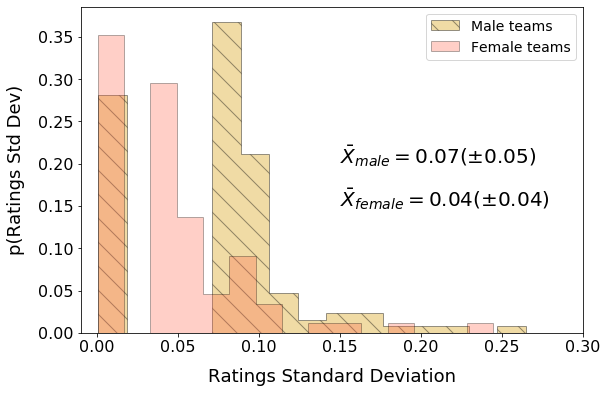

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(9, 6))

plt.hist(team_M_ratings['ratings_std'], 15,weights=np.ones_like(team_M_ratings['ratings_std']) / len(team_M_ratings['ratings_std']),
                             alpha=0.4, histtype='stepfilled', ec='k', facecolor='goldenrod',label=['Male teams'], hatch='\\')

plt.hist(team_F_ratings['ratings_std'], 15,weights=np.ones_like(team_F_ratings['ratings_std']) / len(team_F_ratings['ratings_std']),
                             alpha=0.3, histtype='stepfilled', ec='k', facecolor='tomato',label=['Female teams'])

plt.xlim(-0.01, 0.3)

plt.yticks(size=16)
plt.xticks(size=16)
plt.xlabel('Ratings Standard Deviation', fontsize=18, labelpad=13)
plt.ylabel('p(Ratings Std Dev)', fontsize=18, labelpad=13)
plt.text(0.15, 0.2, '$\\bar{X}_{male}=0.07 (\pm 0.05)$', fontsize=20, weight='bold')
plt.text(0.15, 0.15, '$\\bar{X}_{female}=0.04 (\pm 0.04)$', fontsize=20, weight='bold')
plt.legend(prop={'size': 14})

plt.show()

---

# <font color=orange>II</font>  Statistical Machine Learning Classification Methods

- **Available df**: count_df, len_passM, target, time_pass_M, duel_shot_M, Hind_M, stop_time_M, stop_time_F, team_M_ratings, team_F_ratings, len_passF, time_pass_F, duel_shot_F, Hind_F.


- **Missing df**:  team_AVG_flow (female), team_VAR_flow (female), team_AVG_flow (male), team_VAR_flow (male). [Too much time]

In [44]:
teamM_Flow = pd.merge(team_AVG_flow, team_VAR_flow, on = ['team','match'], how='outer')
teamF_Flow = pd.merge(team_F_AVG_flow, team_F_VAR_flow, on = ['team','match'], how='outer')

team = []
for i in teamsM.find({'type':'national'}):
    team.append([i['name'], i['wyId']])

teamf = []
for i in teamsF.find({'type':'national'}):
    teamf.append([i['name'], i['wyId']])
    
label = []
for i,row in teamM_Flow.iterrows():
    for j in range(len(team)):
        try:
            if row['team'] == team[j][1]:
                label.append(team[j][0])
                teamM_Flow['label'] = label
        except:
            pass
labelf = []
for i,row in teamF_Flow.iterrows():
    for j in range(len(teamf)):
        try:
            if row['team'] == teamf[j][1]:
                labelf.append(teamf[j][0])
                teamF_Flow['label'] = labelf
        except:
            pass

In [45]:
'''
CONFORM the variables' name and type (when needed) and MERGE all the datasets into one.

'''
Hind_M.rename(columns = {'team':'label'}, inplace=True)
stop_time_M.rename(columns = {'beneficiaryTeam':'team'}, inplace=True)
duel_shot_M.rename(columns = {'ContrastTeam':'team'}, inplace=True)
team_M_ratings = team_M_ratings.astype({'team': 'int64'})

Hind_F.rename(columns = {'team':'label'}, inplace=True)
stop_time_F.rename(columns = {'beneficiaryTeam':'team'}, inplace=True)
duel_shot_F.rename(columns = {'ContrastTeam':'team'}, inplace=True)
stop_time_F = stop_time_F.astype({'team': 'int64'})
team_F_ratings = team_F_ratings.astype({'team': 'int64'})
time_pass_F = time_pass_F.astype({'team': 'int64'})
len_pass_F = len_pass_F.astype({'team': 'int64'})
duel_shot_F = duel_shot_F.astype({'team': 'int64'})

count_df = count_df.astype({'team': 'int64'})
target = target.astype({'team': 'int64'})

one = pd.merge(Hind_M, teamM_Flow, on = ['label','match'], how='outer') 
two = pd.merge(one, stop_time_M, on = ['team', 'match'], how = 'outer')
three = pd.merge(two, time_pass_M, on = ['team', 'match'], how = 'outer')
four = pd.merge(three, len_pass_M, on = ['team', 'match'], how = 'outer')
five = pd.merge(four, duel_shot_M, on = ['team', 'match'], how = 'outer')
df_Male = pd.merge(five, team_M_ratings, on = ['team', 'match'], how = 'outer')

a = pd.merge(Hind_F, teamF_Flow, on = ['label','match'], how='outer')
b = pd.merge(a, stop_time_F, on = ['team', 'match'], how = 'outer')
c = pd.merge(b, time_pass_F, on = ['team', 'match'], how = 'outer')
d = pd.merge(c, len_pass_F, on = ['team', 'match'], how = 'outer')
e = pd.merge(d, duel_shot_F, on = ['team', 'match'], how = 'outer')
df_Female = pd.merge(e, team_F_ratings, on = ['team', 'match'], how = 'outer')

un = pd.merge(count_df, target, on = ['team','match','gender'], how='outer')
du = pd.concat([df_Male, df_Female], axis= 0)

absol = pd.merge(du, un, on=['team', 'match'], how = 'outer')
absol.head(10)

,label,meanp,stdp,w,match,meanz,stdz,H_ind,team,avg_team_flow,...,Offside,Others on the ball,Pass,Save attempt,Shot,TotPass,AccurateP,RelAccP,gender,EucDist
0,France,3.152174,2.085717,290,2058014,1.118280,0.384487,1.164079,4418,0.056550,...,1.0,84.0,317.0,2.0,17.0,317,282,0.889590,M,19.921806
1,Belgium,5.474227,5.699219,531,2058014,1.266667,0.647077,1.855353,5629,0.064267,...,1.0,86.0,591.0,5.0,9.0,591,535,0.905245,M,19.731686
2,France,4.884211,4.036702,464,2058017,1.165899,0.450956,1.416493,4418,0.056662,...,1.0,86.0,241.0,3.0,7.0,241,186,0.771784,M,21.871245
3,Croatia,2.150538,1.102825,200,2058017,1.073892,0.280484,0.851322,9598,0.063032,...,1.0,72.0,518.0,7.0,14.0,518,429,0.828185,M,20.212577
4,Uruguay,2.833333,1.891732,255,2058010,1.100806,0.351284,1.077445,15670,0.055929,...,0.0,75.0,304.0,2.0,9.0,304,227,0.746711,M,19.426354
5,France,4.659794,3.526349,452,2058010,1.239295,0.632190,1.730638,4418,0.053976,...,0.0,45.0,510.0,3.0,8.0,510,417,0.817647,M,23.824981
6,Sweden,3.445783,2.369795,286,2058013,1.093750,0.356467,1.127325,7047,0.056551,...,2.0,84.0,345.0,2.0,6.0,345,280,0.811594,M,19.599192
7,England,4.420000,3.146844,442,2058013,1.125592,0.372268,1.213314,2413,0.060519,...,1.0,58.0,485.0,3.0,11.0,485,402,0.828866,M,18.576465
8,Russia,5.524752,4.367136,558,2058012,1.189349,0.494680,1.527145,14358,0.048845,...,1.0,93.0,266.0,2.0,7.0,363,274,0.754821,M,16.306844
9,Croatia,3.382716,2.255925,274,2058012,1.086643,0.340080,1.086177,9598,0.052464,...,0.0,81.0,583.0,4.0,14.0,715,594,0.830769,M,16.870127


In [46]:
'''
Add the information related to the match outcome and identify male teams as class 0 and female teams as class 1.

'''
winner = []
for i in matchesM.find():
    winner.append([i['winner'], i['wyId']])

winnerf = []
for i in matchesF.find():
    winnerf.append([i['winner'], i['wyId']])
    
w = winner + winnerf

outcome = []
for i,row in absol.iterrows():
    for j in range(len(w)):
        if all([row['match'] == w[j][1], row['team']==w[j][0]]):
            outcome.append('W') 
        elif all([row['match'] == w[j][1], row['team']!=w[j][0], w[j][0]!=0]):
            outcome.append('L')
        elif all([row['match'] == w[j][1], w[j][0]==0]):
            outcome.append('D')

absol['outcome'] = outcome
absol.rename({'passTime':'avgPassVelocity(sec)'}, axis=1, inplace=True)
sex = {'M': 0, 'F': 1}
absol.replace({'gender': sex}, inplace=True)

absol.head(10)

,label,meanp,stdp,w,match,meanz,stdz,H_ind,team,avg_team_flow,...,Others on the ball,Pass,Save attempt,Shot,TotPass,AccurateP,RelAccP,gender,EucDist,outcome
0,France,3.152174,2.085717,290,2058014,1.118280,0.384487,1.164079,4418,0.056550,...,84.0,317.0,2.0,17.0,317,282,0.889590,0,19.921806,W
1,Belgium,5.474227,5.699219,531,2058014,1.266667,0.647077,1.855353,5629,0.064267,...,86.0,591.0,5.0,9.0,591,535,0.905245,0,19.731686,L
2,France,4.884211,4.036702,464,2058017,1.165899,0.450956,1.416493,4418,0.056662,...,86.0,241.0,3.0,7.0,241,186,0.771784,0,21.871245,W
3,Croatia,2.150538,1.102825,200,2058017,1.073892,0.280484,0.851322,9598,0.063032,...,72.0,518.0,7.0,14.0,518,429,0.828185,0,20.212577,L
4,Uruguay,2.833333,1.891732,255,2058010,1.100806,0.351284,1.077445,15670,0.055929,...,75.0,304.0,2.0,9.0,304,227,0.746711,0,19.426354,L
5,France,4.659794,3.526349,452,2058010,1.239295,0.632190,1.730638,4418,0.053976,...,45.0,510.0,3.0,8.0,510,417,0.817647,0,23.824981,W
6,Sweden,3.445783,2.369795,286,2058013,1.093750,0.356467,1.127325,7047,0.056551,...,84.0,345.0,2.0,6.0,345,280,0.811594,0,19.599192,L
7,England,4.420000,3.146844,442,2058013,1.125592,0.372268,1.213314,2413,0.060519,...,58.0,485.0,3.0,11.0,485,402,0.828866,0,18.576465,W
8,Russia,5.524752,4.367136,558,2058012,1.189349,0.494680,1.527145,14358,0.048845,...,93.0,266.0,2.0,7.0,363,274,0.754821,0,16.306844,L
9,Croatia,3.382716,2.255925,274,2058012,1.086643,0.340080,1.086177,9598,0.052464,...,81.0,583.0,4.0,14.0,715,594,0.830769,0,16.870127,W


In [47]:
'''
MAIN GOAL:

Given the vector of performance and technical skills of a national football team in a certain game, 
the goal is to classify each team as male (class 0) or female (class 1).

'''

X = absol[['label', 'team', 'match','outcome','gender','H_ind', 'avg_team_flow','var_team_flow','avg_stopTime','Duel','Foul', 'Free Kick', 'Goalkeeper leaving line', 'Offside',
           'Others on the ball', 'Pass', 'Save attempt', 'Shot','RelAccP','EucDist',
           'avgPassVelocity(sec)','recoveryTime','avgLenPass(mt)','difDuel','difShot','avg_ratings','ratings_std']] 
y = absol['gender']

'''
FIRST experiment: 

Split the entire dataset into train (80%) and validation (20%) set in order to select the best tuning parameters
of the classifier on the validation set via 5-fold Cross Validation, and then validate each method 
on the training set through 10-fold Cross Validation. The split was done considering the class distribution in the entire dataset.

NB It was also saved a set with scaled variables; it will be used for the baseline and the logistic classifier. 

'''
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,  stratify=y, random_state=1)

X1 = X_train[X_train.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]
Xv = X_val[X_val.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X1)
X_train_sc = pd.DataFrame(X_train_sc, columns=X1.columns)

In [61]:
'''
The 'GridSearchCV' function is used in order to find the best tuning parameters of the classifiers. There are considered: 
the Decision Tree classifier, the Random Forest and the Adaboost. There are chosen the parameters that maximaze the 
5-fold CV accuracy, computed in the validation set.

NB The results may vary a bit, because in this phase the 'random state' value was not fixed. 

'''
Tree_parameters = {'criterion':('gini', 'entropy'), 'splitter':('best', 'random'), 'ccp_alpha':list(np.linspace(0.0, 0.2, 20))}
tree = DecisionTreeClassifier() 

Tree_grid = GridSearchCV(tree, Tree_parameters, cv=5, scoring ='accuracy')
Tree_grid.fit(Xv, y_val)
Tree_grid.best_params_

''''''
Forest_parameters = {'criterion':('gini', 'entropy'), 'max_features':('auto', 'log2'), 
               'max_depth':[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],'ccp_alpha':list(np.linspace(0.0, 0.2, 20)),
               'min_samples_split':[2, 5, 10, 15]}

forest = RandomForestClassifier() 

Forest_grid = GridSearchCV(forest, Forest_parameters, cv=5, scoring ='accuracy')
Forest_grid.fit(Xv, y_val)
Forest_grid.best_params_

''''''
ADparameters = {'n_estimators':[50, 100, 150, 200, 250, 300, 350, 400, 450], 
                'learning_rate':[0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2]}

adab = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1) # Stump Tree 
)

ADgrid = GridSearchCV(adab, ADparameters, cv=5, scoring='accuracy')
ADgrid.fit(Xv, y_val)
ADgrid.best_params_

KeyboardInterrupt: 

In [48]:
'''
Having selected the best tuning parameters of each classifiers we validate them on the training set via 10-fold CV, computing the
measure of accuracy and F1-score.

'''
dummy_clf = DummyClassifier(strategy="stratified") 

scores = cross_val_score(dummy_clf, X_train_sc, y_train, cv=10, scoring='accuracy') 
print('DUMMY CLF: Cv mean Accuracy is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

scores = cross_val_score(dummy_clf, X_train_sc, y_train, cv=10, scoring='f1') 
print('DUMMY CLF: Cv mean F1-score is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

'''
NB In the Logistic classifier we don't have parameters to choose, so we can fast measure the 10-Fold CV mean accuracy and F1-score
''' 
logmodel = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')

scores = cross_val_score(logmodel, X_train_sc, y_train, cv=10, scoring='accuracy') 
print('LOGISTIC CLF: Cv mean Accuracy is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

scores = cross_val_score(logmodel, X_train_sc, y_train, cv=10, scoring='f1') 
print('LOGISTIC CLF: Cv mean F1-score is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

''''''
dtree = DecisionTreeClassifier(ccp_alpha= 0.021052631578947368,criterion= 'gini', splitter= 'best')

scores = cross_val_score(dtree, X1, y_train, cv=10, scoring='accuracy') 
print('DECISION TREE CLF: Cv mean Accuracy is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

scores = cross_val_score(dtree, X1, y_train, cv=10, scoring='f1') 
print('DECISION TREE CLF: Cv mean F1-score is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

''''''
rforest = RandomForestClassifier(n_estimators=100, ccp_alpha=0.010526315789473684, criterion= 'gini',
                                max_depth=25, max_features= 'auto', min_samples_split= 2)

scores = cross_val_score(rforest, X1, y_train, cv=10, scoring='accuracy') 
print('RANDOM FOREST CLF: Cv mean Accuracy is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

scores = cross_val_score(rforest, X1, y_train, cv=10, scoring='f1') 
print('RANDOM FOREST CLF: Cv mean F1-score is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

''''''
adaboost = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), # Stump Tree
    n_estimators=250, learning_rate=1.5)

scores = cross_val_score(adaboost, X1, y_train, cv=10, scoring='accuracy') 
print('ADABOOST CLF: Cv mean Accuracy is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

scores = cross_val_score(adaboost, X1, y_train, cv=10, scoring='f1') 
print('ADABOOST CLF: Cv mean F1-score is equal to ' + str(scores.mean()) + ', with std equal to ' + str(scores.std()))

DUMMY CLF: Cv mean Accuracy is equal to 0.5003267973856209, with std equal to 0.14463839638826803
DUMMY CLF: Cv mean F1-score is equal to 0.4185009598244892, with std equal to 0.2072634055821051
LOGISTIC CLF: Cv mean Accuracy is equal to 0.9248366013071895, with std equal to 0.06333464860327134
LOGISTIC CLF: Cv mean F1-score is equal to 0.9117302305537599, with std equal to 0.07093760429622005
DECISION TREE CLF: Cv mean Accuracy is equal to 0.8666666666666668, with std equal to 0.07314423442372697
DECISION TREE CLF: Cv mean F1-score is equal to 0.8376190476190475, with std equal to 0.0830867098911987
RANDOM FOREST CLF: Cv mean Accuracy is equal to 0.9477124183006536, with std equal to 0.06075267994050851
RANDOM FOREST CLF: Cv mean F1-score is equal to 0.925970695970696, with std equal to 0.0774405150393568
ADABOOST CLF: Cv mean Accuracy is equal to 0.9369281045751634, with std equal to 0.045939158176928646
ADABOOST CLF: Cv mean F1-score is equal to 0.9109324009324009, with std equal to

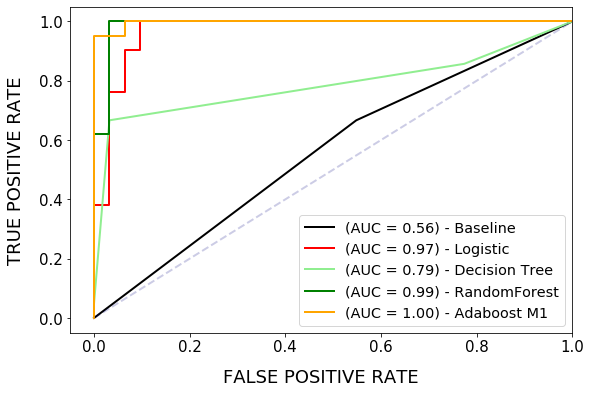

In [75]:
'''
Predictive performance evaluation via ROC CURVES representation. Here the training data set 
was splitted into a second Training set (70%) and into a Test-set (30%). Every classifier is trained on the second training set
and the class predictions are made using the test set. 

'''
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=26) # NB one configuration choosen by me

X2 = X_train2[X_train2.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]
X_t = X_test[X_test.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]

X2_train_sc = scaler.fit_transform(X2)
X2_train_sc = pd.DataFrame(X2_train_sc, columns=X2.columns)
X_test_sc = scaler.fit_transform(X_t)
X_test_sc = pd.DataFrame(X_test_sc, columns=X2.columns)

dummy_clf.fit(X2_train_sc, y_train2)
bprobs = dummy_clf.predict_proba(X_test_sc) # variables SCALED 
bfpr, btpr, thresholds = roc_curve(y_test, bprobs[:,1])
broc_auc = roc_auc_score(y_test, bprobs[:,1])

logmodel.fit(X2_train_sc, y_train2)
lprobs = logmodel.predict_proba(X_test_sc) # variables SCALED
lfpr, ltpr, thresholds = roc_curve(y_test, lprobs[:,1]) 
lroc_auc = roc_auc_score(y_test, lprobs[:,1])

dtree.fit(X2, y_train2)
tprobs = dtree.predict_proba(X_t)
tfpr, ttpr, thresholds = roc_curve(y_test, tprobs[:,1]) 
troc_auc = roc_auc_score(y_test, tprobs[:,1])

rforest.fit(X2, y_train2)
probsRF = rforest.predict_proba(X_t)
ffpr, ftpr, thresholds = roc_curve(y_test, probsRF[:,1])
froc_auc = roc_auc_score(y_test, probsRF[:,1])

adaboost.fit(X2, y_train2)
probsAD = adaboost.predict_proba(X_t)
bofpr, botpr, thresholds = roc_curve(y_test, probsAD[:,1]) 
boroc_auc = roc_auc_score(y_test, probsAD[:,1])

fig = plt.figure(figsize=(9, 6))
plt.plot(bfpr, btpr, color='black',lw=2, label='(AUC = %0.2f)' % broc_auc + ' - Baseline')
plt.plot(lfpr, ltpr, color='red',lw=2, label='(AUC = %0.2f)' %  lroc_auc + ' - Logistic')
plt.plot(tfpr, ttpr, color='lightgreen',lw=2, label='(AUC = %0.2f)' % troc_auc + ' - Decision Tree')
plt.plot(ffpr, ftpr, color='green',lw=2, label='(AUC = %0.2f)' %  + froc_auc + ' - RandomForest')
plt.plot(bofpr, botpr, color='orange',lw=2, label='(AUC = %0.2f)' %  + boroc_auc + ' - Adaboost M1')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('FALSE POSITIVE RATE', weight='normal', fontsize=18, labelpad=14)
plt.ylabel('TRUE POSITIVE RATE', weight='normal', fontsize=18,labelpad=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize='x-large')
plt.show()

In [49]:
'''
SECOND experiment:

I'll take 70% of the training data set as a second Training set and the remaining 30% as a Test-set; 
these splits are made N times in order to stabilize the feature importance measures of the Decision Tree classifier 
and reduce the potential variability in the choice of the best features that help the model in the football team classification.  
At every split it was taken the 'feature_importance' measure for each variables.

'''
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1) # I recall the first split of the entire dataset

trees = []
rs_range = range(20)

for rs in rs_range:
    X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=rs)
    X2 = X_train2[X_train2.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]
    X_t = X_test[X_test.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]
    
    dtree = DecisionTreeClassifier(ccp_alpha= 0.021052631578947368, criterion= 'gini', splitter= 'best', random_state=0)
    trees.append(dtree.fit(X2, y_train2))

impo_feature=[]
d={}
features={}

for tree in trees:
    impo_feature.append(tree.feature_importances_)
    
for i in range(len(impo_feature)):
    for j in range(len(impo_feature[i])):
        d[X2.columns[j]] = impo_feature[i][j]
        
        d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = True)}        
        features[i] = d    

In [50]:
'''
The differences in each variables' 'feature importance' value, for each pair of trees, 
was measured by Normalized Root Mean Square Error.

'''
import math as m

def nrmse(list_1, list_2): # respect to the 'measure_importance' value
    
    diff = []
    for i in range(len(list_1)):
        
        diff.append((list_1[i] - list_2[i])**2)
        som = sum(diff)
        
        result = m.sqrt((1/len(list_1))*som)/(max(list_1)-min(list_1))
    return result

final={}
t={} 
dref = features[0] # Reference dictionary for ordering features (i.e. ratings_std, avgPassVel, recoveryTime, ratings, relAccp, etc...)

for dict_j in features:
    for dict_i in features:
        
        t1 = features[dict_j]
        t2 = features[dict_i]
        
        values_t1, values_t2 = [], []
        
        for key in  dref:
            v1 =  t1[key]
            v2 =  t2[key]
            values_t1.append(v1)
            values_t2.append(v2)
        final[dict_j, dict_i] = nrmse(values_t1, values_t2)

scorp=[]
for i in range(20):
    for j in range(20):
        scorp.append([i, j, final[i,j]])
        nrmse_df = pd.DataFrame(scorp, columns=['Tr','Tc','NRMSE'])
        nrmse_pv = nrmse_df.pivot('Tr', 'Tc', 'NRMSE')

nrmse_df.head(10)

,Tr,Tc,NRMSE
0,0,0,0.000000
1,0,1,0.193307
2,0,2,0.259340
3,0,3,0.157269
4,0,4,0.207462
5,0,5,0.399701
6,0,6,0.224208
7,0,7,0.172309
8,0,8,0.403779
9,0,9,0.196680


In [51]:
'''
Moreover, the differences in the variables' ranks based on their 'feature importance' values, for each pair of trees, 
were computed by Kendall's τ coefficient.

NB Instead of 'dref' you can put every list of variables of interest and compute these two indices to evaluate the grade of 
concordance between every pair of trees, about the importance of that specific variables in the classification task.
   
   Also you can do this operation for each classifier you have. 
'''
def kendall(list_1, list_2):
    result = stats.kendalltau(list_1, list_2)     
    return result[0]

final={}
t={} 
dref = features[0] # Reference dictionary for ordering features

for dict_j in features:
    for dict_i in features:
        
        t1 = features[dict_j]
        t2 = features[dict_i]
        rank_1 = {key: rank for rank, key in enumerate(sorted(t1, key=t1.get, reverse = True), 1)}
        rank_2 = {key: rank for rank, key in enumerate(sorted(t2, key=t2.get, reverse = True), 1)}
        
        values_t1, values_t2 = [], []
        
        for key in  dref: # put the reference dictionary!
            v1 =  rank_1[key]
            v2 =  rank_2[key]
            values_t1.append(v1)
            values_t2.append(v2)
        
        final[dict_j, dict_i] = kendall(values_t1, values_t2)

scorp=[]

for i in range(20):
    for j in range(20):
        scorp.append([i, j, final[i,j]])
        kendal_df = pd.DataFrame(scorp, columns=['Tr','Tc','Kendall-Tau'])
        kendal_pv = kendal_df.pivot('Tr', 'Tc', 'Kendall-Tau')
        
kendal_df.head(10)

,Tr,Tc,Kendall-Tau
0,0,0,1.000000
1,0,1,0.731602
2,0,2,0.593074
3,0,3,0.558442
4,0,4,0.506494
5,0,5,0.428571
6,0,6,0.489177
7,0,7,0.497835
8,0,8,0.437229
9,0,9,0.489177


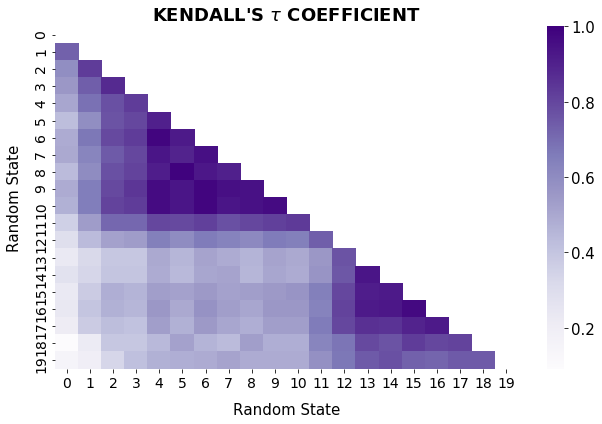

In [52]:
'''
Visualize the heatmap of the Kendall's τ coefficient between all the pairs of set 
of feature rankings based 'feature importance' values. There are considered ALL the features available.

'''
mask = np.zeros_like(kendal_pv, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(9,6))

ax = sns.heatmap(kendal_pv, cmap='Purples', mask=mask)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

plt.xlabel('Random State', fontsize=15, labelpad=12)
plt.ylabel('Random State', fontsize=15, labelpad=12)
plt.title('KENDALL\'S $\\tau$ COEFFICIENT', fontsize=18, weight='bold')
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

In [53]:
rank_feature={}

for i in range(len(features)):
    rank_feature[i] = {key: rank for rank, key in enumerate(sorted(features[i], key=features[i].get, reverse = True), 1)}
rank_features = pd.DataFrame(rank_feature).T

print('RATINGS\' STD: avg rank = ' + str(rank_features['ratings_std'].mean()) + ', std rank = ' + str(rank_features['ratings_std'].std())) 
print('PASS ACCURACY (%): avg rank = ' + str(rank_features['RelAccP'].mean()) + ', std rank = ' + str(rank_features['RelAccP'].std())) 
print('BALL POSSESSION RECOVERY TIME: avg rank = ' + str(rank_features['recoveryTime'].mean()) + ', std rank = ' + str(rank_features['recoveryTime'].std())) 
print('AVG PASS VELOCITY (sec): avg rank = ' + str(rank_features['avgPassVelocity(sec)'].mean()) + ', std rank = ' + str(rank_features['avgPassVelocity(sec)'].std())) 

RATINGS' STD: avg rank = 1.95, std rank = 1.820208200931103
PASS ACCURACY (%): avg rank = 2.9, std rank = 1.58612404107756
BALL POSSESSION RECOVERY TIME: avg rank = 3.2, std rank = 1.0563093645728086
AVG PASS VELOCITY (sec): avg rank = 4.95, std rank = 3.9666371810786774


In [54]:
'''
FINALLY, here is presented a method to focus on just the FULL matches the test predictions, randomly extracted at each 
(second)train-test split. It is possible to select just the 'wrong' matches and analyse the teams' technical skills vectors. 

'''
predictions=[]
rs_range = range(30)

for rs in rs_range:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=rs)
    
    X2 = X_train2[X_train2.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]
    X_t = X_test[X_test.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]
    
    full_matches = X_test[X_test.duplicated(subset=['match'],keep=False)].sort_values(by=['match']) # take just the 'full_match' in the test set
    full_m = full_matches[full_matches.columns.difference(['label', 'match', 'team','gender','outcome'], sort=False)]
    
    dtree = DecisionTreeClassifier(ccp_alpha= 0.021052631578947368, criterion= 'gini', splitter= 'best', random_state=0)
    dtree.fit(X2, y_train2)
    tpreds = dtree.predict(full_m) # take the predictions of that observations that correspond to 'full_matches'
    
    for i in range(len(full_matches)):
        if full_matches.iloc[i]['gender']==tpreds[i]:
            predictions.append(['Correct', full_matches.iloc[i]['label'], full_matches.iloc[i]['match'],full_matches.iloc[i]['gender'],tpreds[i]])
        else:
            predictions.append(['Wrong', full_matches.iloc[i]['label'], full_matches.iloc[i]['match'],full_matches.iloc[i]['gender'],tpreds[i]])  
    
    predictions_df = pd.DataFrame(predictions, columns=['outcome', 'team', 'match', 'RealClass', 'PredClass'])

preds_full_matches = predictions_df.drop_duplicates(subset=['team', 'match']) # drop the matches drawn several times
preds_full_matches.head(10)

,outcome,team,match,RealClass,PredClass
0,Correct,Portugal,2057964,0,0
1,Correct,Iran,2057964,0,0
2,Correct,Argentina,2057972,0,0
3,Correct,Iceland,2057972,0,0
4,Correct,Croatia,2057973,0,0
5,Wrong,Nigeria,2057973,0,1
6,Correct,Mexico,2057989,0,0
7,Correct,Sweden,2057989,0,0
8,Correct,South Africa,2826518,1,1
9,Correct,Germany,2826518,1,1
